# Resultados de la prueba subjetiva

Imports

In [7]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from pymongo.server_api import ServerApi


Cargar la colección

In [8]:
uri = f"mongodb+srv://{st.secrets['db_username']}:{st.secrets['db_pswd']}@{st.secrets['cluster_name']}.j8rqe.mongodb.net/?retryWrites=true&w=majority&appName=test-subjetivo"

client = pymongo.MongoClient(uri, server_api=ServerApi('1'))
db = client["results_db"]
collection = db["results_collection"]

client.admin.command("ping")
print("Connected successfully")

Connected successfully


Leer los resultados

In [9]:
data = list(collection.find())
df = pd.DataFrame(data)
resultados = pd.json_normalize(df['resultados'])
df_final = pd.concat([df[['id_participante', 'edad', 'genero', 'sistema', 'experiencia']], resultados], axis=1)
df_final.to_csv('results.csv')

Estilo de los graficos

In [10]:
plt.style.use('bmh')
sns.set_theme(style="whitegrid", context="talk")

Ploteo los resultados para silentcipher

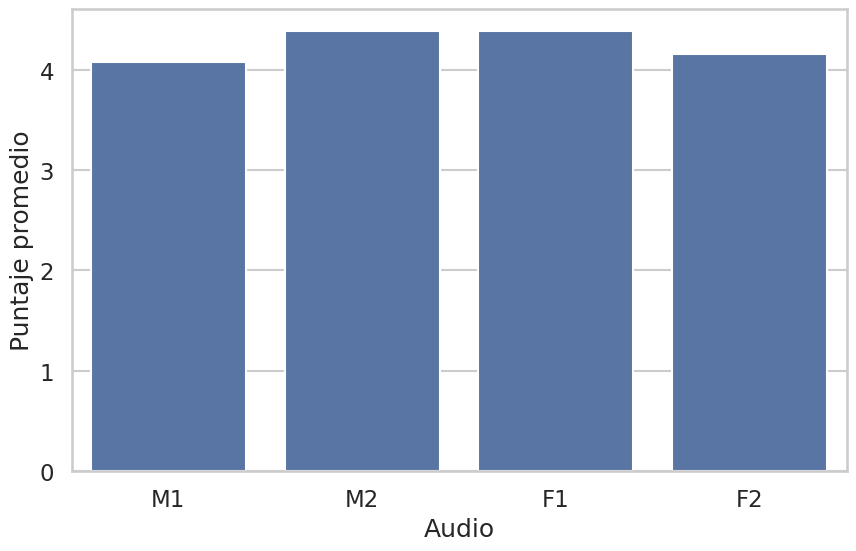

In [11]:

columns_as = [col for col in df_final.columns if col.endswith('_as')]
df_as = df_final[columns_as]

columns_sc = [col for col in df_final.columns if col.endswith('_sc')]
df_sc = df_final[columns_sc]

columns_wm = [col for col in df_final.columns if col.endswith('_wm')]
df_wm = df_final[columns_wm]

columns_or = [col for col in df_final.columns if col.endswith('_or')]
df_or = df_final[columns_or]

puntajes_promedio_or = df_or.mean()
puntajes_promedio_or.index = puntajes_promedio_or.index.str.replace('_or', '')
puntajes_promedio_or = puntajes_promedio_or.reindex(['M1', 'M2', 'F1', 'F2'])

plt.figure(figsize=(10, 6))
sns.barplot(x=puntajes_promedio_or.index, y=puntajes_promedio_or.values)
plt.ylabel('Puntaje promedio')
plt.xlabel('Audio')
plt.xticks()  # Rotar las etiquetas si es necesario
plt.savefig('plots/original.svg')
plt.show()

Comparaciones A/A: 4.25 stdev: 0.88
Silentcipher: 4.13 stdev: 0.82
Audioseal: 4.02 stdev: 1.04
Wavmark: 3.42 stdev: 1.04


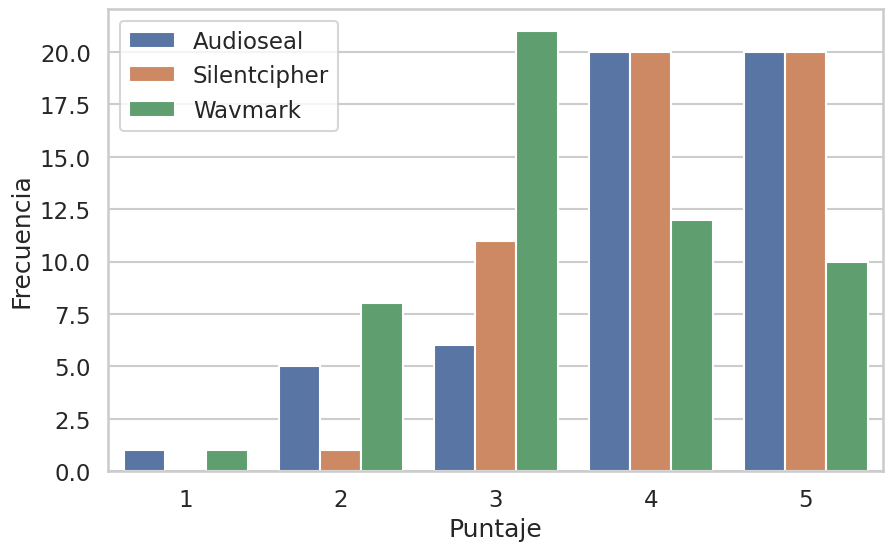

In [14]:
puntajes_as = df_as.melt(value_name='puntaje')['puntaje']
puntajes_sc = df_sc.melt(value_name='puntaje')['puntaje']
puntajes_wm = df_wm.melt(value_name='puntaje')['puntaje']
puntajes_or = df_or.melt(value_name='puntaje')['puntaje']

print(f'Comparaciones A/A: {puntajes_or.mean():.2f} stdev: {puntajes_or.std():.2f}')
print(f'Silentcipher: {puntajes_sc.mean():.2f} stdev: {puntajes_sc.std():.2f}')
print(f'Audioseal: {puntajes_as.mean():.2f} stdev: {puntajes_as.std():.2f}')
print(f'Wavmark: {puntajes_wm.mean():.2f} stdev: {puntajes_wm.std():.2f}')


puntajes_posibles = range(1, 6)

frecuencias_puntajes_as = puntajes_as.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_sc = puntajes_sc.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_wm = puntajes_wm.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()
frecuencias_puntajes_or = puntajes_or.value_counts().reindex(puntajes_posibles, fill_value=0).sort_index()

frecuencias_df = pd.DataFrame({
    'Audioseal': frecuencias_puntajes_as,
    'Silentcipher': frecuencias_puntajes_sc,
    'Wavmark': frecuencias_puntajes_wm})

# Crear un DataFrame para cada sistema con una columna 'Sistema' indicando el origen
df_as_long = pd.DataFrame({'puntaje': puntajes_as, 'Sistema': 'Audioseal'})
df_sc_long = pd.DataFrame({'puntaje': puntajes_sc, 'Sistema': 'Silentcipher'})
df_wm_long = pd.DataFrame({'puntaje': puntajes_wm, 'Sistema': 'Wavmark'})
df_or_long = pd.DataFrame({'puntaje': puntajes_or, 'Sistema': 'Original'})

# Combinar todos los DataFrames en uno solo
df_combined = pd.concat([df_as_long, df_sc_long, df_wm_long])
df_combined['Sistema'] = pd.Categorical(df_combined['Sistema'], categories=['Audioseal', 'Silentcipher', 'Wavmark'], ordered=True)

frecuencia_puntajes = df_combined.groupby(['puntaje', 'Sistema'], observed=True).size().reset_index(name='Frecuencia')

# Crear el histograma con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='puntaje', y='Frecuencia', hue='Sistema', data=frecuencia_puntajes, dodge=True)

plt.xlabel('Puntaje')
plt.ylabel('Frecuencia')
plt.xticks()
plt.legend()
plt.savefig('plots/dmos_histograma.svg')
plt.show()
